In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')

import jax
jax.config.update('jax_platform_name', 'cpu')


from typing import Any
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader

from mtr.config import cfg, cfg_from_yaml_file

from bc.behavior_cloning import BehaviorCloning
from bc.bc_dataset import BCDataset

torch.set_float32_matmul_precision('high')
cfg_file = 'tools/cfgs/waymo/bc_atten_discrete.yaml'
cfg_from_yaml_file(cfg_file, cfg)

model_path = 'output/bc_discrete_4_freeze/epoch=0-step=100000.ckpt'

# model_dict = torch.load(model_path, map_location='cpu')['state_dict']

BC = BehaviorCloning.load_from_checkpoint(model_path, map_location='cpu')

# BC = BehaviorCloning(cfg)
# BC.encoder.load_model(model_dict)
# BC.decoder.load_model(model_dict)

_ = BC.to('cuda')
_ = BC.eval()

# Dataset
val_dataset = BCDataset(
    cfg.DATA.VAL_PATH,
    sample_method='log'
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=1,
    pin_memory=True, 
    num_workers=0,
    shuffle=False, 
    collate_fn=val_dataset.collate_fn,
)

/home/zixuzhang/mambaforge/envs/waymax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Test with iter

In [5]:
# fake dataset
from waymax import config as _config
from waymax import visualization
from waymax.dynamics.bicycle_model import compute_inverse
from rl_env.waymax_util import WomdLoader
from rl_env.env_utils import merge_dict, process_input
import mediapy

WOMD_1_2_0_VAL_LOCAL = _config.DatasetConfig(
    path='/Data/Dataset/Waymo/V1_2_tf/validation_interactive/validation_interactive_tfexample.tfrecord@150',
    # path='/Data/Dataset/Waymo/V1_2_tf/validation/validation_tfexample.tfrecord@150',
    # path='/Data/Dataset/Waymo/V1_2_tf/training/training_tfexample.tfrecord@1000',
    max_num_rg_points=30000,
    data_format=_config.DataFormat.TFRECORD,
    max_num_objects=32,
    shuffle_seed = 0,
)
data_iter = WomdLoader(data_config=WOMD_1_2_0_VAL_LOCAL)



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


""

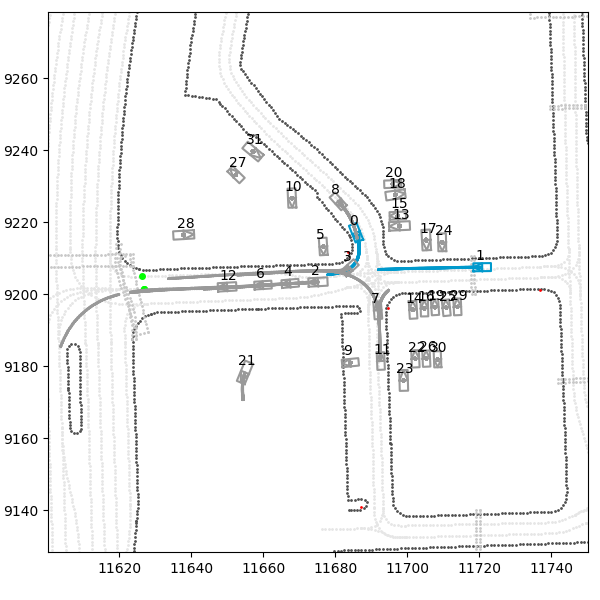

In [6]:
scenario_id, scenario = data_iter.next()
img = visualization.plot_simulator_state(scenario, use_log_traj=True, highlight_obj = _config.ObjectType.MODELED)
mediapy.show_image(img)

In [7]:
from scipy.signal import savgol_filter
import copy
from waymax.datatypes import SimulatorState, Trajectory
import jax.numpy as jnp
from scipy.interpolate import interp1d

def preprocess_scenario(scenario: SimulatorState, all_agent: bool = False):
    traj = scenario.log_trajectory
    original_valid = np.asarray(traj.valid)
    vel = np.stack(
      [traj.vel_x, traj.vel_y], axis=-1
    )
    num_agent, num_step = traj.valid.shape
    
    accel = np.zeros((num_agent, num_step-1))
    steer = np.zeros((num_agent, num_step-1))
    t = np.arange(num_step)
    for i in range(num_agent):
        valid = original_valid[i]
        valid_idx = np.where(valid)[0]
        if len(valid_idx) > 0: 
          first_valid_idx = valid_idx[0]
          last_valid_idx = valid_idx[-1]
          t_valid = t[valid]
          vel_valid = vel[i][valid, :]
          vel_interp = interp1d(t_valid, vel_valid, axis=0,  kind='cubic')

          t_interped = np.arange(first_valid_idx, last_valid_idx+1)
          vel_interped = vel_interp(t_interped)
          vel_smoothed = savgol_filter(vel_interped, min(last_valid_idx-first_valid_idx, 21), 3, axis=0)

          speed_smoothed = np.linalg.norm(vel_smoothed, axis=-1)
          accel[i, first_valid_idx:last_valid_idx] = np.diff(speed_smoothed)
        
        
        
    
    
    

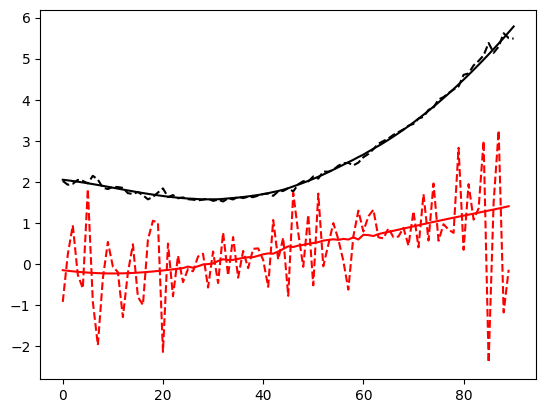

In [15]:
# def test():
traj = scenario.log_trajectory
original_valid = np.asarray(traj.valid)

vel = np.stack(
  [traj.vel_x, traj.vel_y, traj.yaw], axis=-1
)

i = 0
num_agent, num_step = traj.valid.shape
t = np.arange(num_step)

valid = original_valid[i]
valid_idx = np.where(valid)[0]
if len(valid_idx) > 0: 
  first_valid_idx = valid_idx[0]
  last_valid_idx = valid_idx[-1]
  t_valid = t[valid]
  vel_valid = vel[i][valid, :]
  vel_interp = interp1d(t_valid, vel_valid, axis=0,  kind='cubic')

  t_interped = np.arange(first_valid_idx, last_valid_idx+1)
  vel_interped = vel_interp(t_interped)
  vel_smoothed = savgol_filter(vel_interped, min(last_valid_idx-first_valid_idx, 51), 3, axis=0)

  speed_smoothed = np.linalg.norm(vel_smoothed, axis=-1)
  # plt.plot(t, vel[i, :, 0], '--',)
  # plt.plot(t_interped, vel_interped[:, 0], '-')
  speed = np.linalg.norm(vel[i], axis=-1)
  plt.plot(t_interped, speed_smoothed, 'k-')
  plt.plot(t, speed, 'k--')
  plt.plot(t_interped[:-1], np.diff(speed_smoothed)/0.1, 'r-')
  plt.plot(t[:-1], np.diff(speed)/0.1, 'r--')

# %timeit test()

In [ ]:
import jax.numpy as jnp 
from scipy.signal import savgol_filter
import copy

traj = copy.deepcopy(scenario.log_trajectory)
# print(traj.vel_x.shape)
# traj.vel_x = savgol_filter(traj.vel_x, 51, 3, axis = -1)
# traj.vel_y = savgol_filter(traj.vel_y, 51, 3, axis = -1)
xy_yaw_vel = np.stack(
      [traj.x, traj.y, traj.yaw, traj.vel_x, traj.vel_y], axis=-1
  )
# print(xy_yaw_vel)

a = 0
speed = np.sqrt(xy_yaw_vel[a, :, 3]**2 + xy_yaw_vel[a, :, 4]**2)
plt.plot(speed)

t = np.arange(len(speed))

valid = np.zeros_like(speed, dtype=bool)
valid[10:45] = True
valid[50:70] = True
valid[50:] = True
t_valid   = t[valid]
speed_valid = speed[valid]
print(np.where(valid))

# interp 
from scipy.interpolate import interp1d
speed_interp = interp1d(t_valid, speed_valid, kind='cubic')
plt.plot(speed_interp(t), '--')

# plt.plot(xy_yaw_vel[a, :, 4])



In [ ]:
is_ctrl = np.zeros(32, dtype=bool)
is_ctrl[0] = True
t= 60

In [ ]:
t = 60
input = process_input(
    scenario,
    is_ctrl,
    from_gt=True,
    current_time_index=t,
    hide_history=11
    )
gt_action = np.asarray(
    compute_inverse(scenario.log_trajectory, t, estimate_yaw_with_velocity=True).data[is_ctrl]
)
input['gt_action'] = gt_action
batch = merge_dict([input], 'cuda')


BC.zero_grad()
encoder_output = BC.encoder(batch, retain_input=True)
decoder_output = BC.decoder(encoder_output)
total_loss_best, tb_dict_best = BC.decoder.get_loss(decoder_output, debug = True)
# total_loss_best, tb_dict_best = BC.decoder.get_loss_best(decoder_output, debug = True)
# total_loss_gmm, tb_dict_gmm = BC.decoder.get_loss_gmm(decoder_output)

print(BC.decoder.sample(decoder_output, True))

print('best', total_loss_best)
print(tb_dict_best)

# print('gmm', total_loss_gmm)
# print(tb_dict_gmm)

t += 5

# Test with Dataset


In [3]:
BC.decoder.pred_all_layers = False
bin_idx = np.random.choice(len(val_dataset.sample_p), p=val_dataset.sample_p)
cache_id = np.random.randint(val_dataset.histogram[bin_idx])
cache = val_dataset.idx_cache[bin_idx][cache_id]
print(cache)

[29235, 13, 3]


tensor([[ 1.6187, -0.0782]])


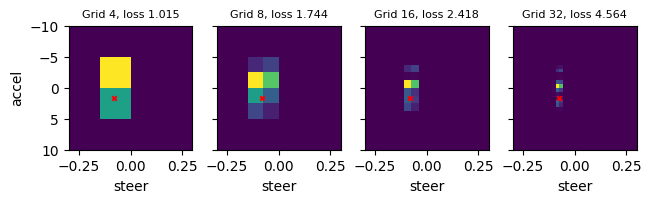

In [4]:

input_dict = val_dataset.retrive_one(cache, hide_history=11)
batch = val_dataset.collate_fn([input_dict])
encoder_output = BC.encoder(batch, retain_input=True)
decoder_output = BC.decoder(encoder_output)
total_loss_best, tb_dict_best = BC.decoder.get_loss(decoder_output, debug = True)